## 데이터

- [다운로드 링크](https://drive.google.com/file/d/1QlhGFIFwEkNEjQGOvV_hQe4bnOLDJwCR/view)
- 출처: [Jamin Ball Blog](https://cloudedjudgement.substack.com/p/clouded-judgement-111023).


## 패키지

`unstructured`를 사용하기 위해서는 시스템에 `poppler`([설치 지침](https://pdf2image.readthedocs.io/en/latest/installation.html))와 `tesseract`([설치 지침](https://tesseract-ocr.github.io/tessdoc/Installation.html))가 필요합니다.

[참고] `옵션 2`는 다중 모달 LLM을 답변 합성에 사용할 수 없는 경우(예: 비용 등)에 적합합니다.


In [1]:
# ! pip install -U langchain openai chromadb langchain-experimental # 최신 버전이 필요합니다 (멀티 모달을 위해)

In [ ]:
# ! pip install "unstructured[all-docs]" pillow pydantic lxml pillow matplotlib chromadb tiktoken

## 데이터 로딩

### PDF 텍스트와 이미지 분할

[Unstructured](https://unstructured-io.github.io/unstructured/introduction.html#key-concepts)에서 제공하는 `partition_pdf`를 사용하여 텍스트와 이미지를 추출할 수 있습니다.

이미지를 추출하기 위해 다음을 사용합니다

`extract_images_in_pdf=True`

텍스트만 처리하려는 경우.

`extract_images_in_pdf=False`


In [1]:
import os
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

os.environ["OPENAI_API_KEY"] = os.getenv("KADAP_OPENAI_API_KEY")

In [2]:
# 파일 경로
fpath = "./data"
fname = "모빌리티 인사이트_23년 4월호_최종_web.pdf"

In [8]:
import os
from langchain_text_splitters import CharacterTextSplitter
from unstructured.partition.pdf import partition_pdf

# PDF에서 요소 추출


def extract_pdf_elements(path, fname):
    """
    PDF 파일에서 이미지, 테이블, 그리고 텍스트 조각을 추출합니다.
    path: 이미지(.jpg)를 저장할 파일 경로
    fname: 파일 이름
    """
    return partition_pdf(
        filename=os.path.join(path, fname),
        extract_images_in_pdf=True,  # PDF 내 이미지 추출 활성화
        infer_table_structure=True,  # 테이블 구조 추론 활성화
        chunking_strategy="by_title",  # 제목별로 텍스트 조각화
        max_characters=4000,  # 최대 문자 수
        new_after_n_chars=3800,  # 이 문자 수 이후에 새로운 조각 생성
        combine_text_under_n_chars=2000,  # 이 문자 수 이하의 텍스트는 결합
        image_output_dir_path=path,  # 이미지 출력 디렉토리 경로
    )


# 요소를 유형별로 분류


def categorize_elements(raw_pdf_elements):
    """
    PDF에서 추출된 요소를 테이블과 텍스트로 분류합니다.
    raw_pdf_elements: unstructured.documents.elements의 리스트
    """
    tables = []  # 테이블 저장 리스트
    texts = []  # 텍스트 저장 리스트
    for element in raw_pdf_elements:
        if "unstructured.documents.elements.Table" in str(type(element)):
            tables.append(str(element))  # 테이블 요소 추가
        elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
            texts.append(str(element))  # 텍스트 요소 추가
    return texts, tables


# 요소 추출
raw_pdf_elements = extract_pdf_elements(fpath, fname)

# 텍스트, 테이블 추출
texts, tables = categorize_elements(raw_pdf_elements)

# 선택사항: 텍스트에 대해 특정 토큰 크기 적용
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=4000, chunk_overlap=0  # 텍스트를 4000 토큰 크기로 분할, 중복 없음
)
joined_texts = " ".join(texts)  # 텍스트 결합
texts_4k_token = text_splitter.split_text(joined_texts)  # 분할 실행

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
len(texts_4k_token)

47

## 멀티-벡터 검색기

[multi-vector-retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary)를 사용하여 이미지(그리고/또는 텍스트, 테이블) 요약을 색인화하지만, 원본 이미지(원본 텍스트나 테이블과 함께)를 검색합니다.

### 텍스트 및 테이블 요약

테이블과 선택적으로 텍스트 요약을 생성하기 위해 `GPT-4-turbo`를 사용할 것입니다.

큰 청크 크기를 사용하는 경우(예를 들어, 위에서 설정한 것처럼 4k 토큰 청크를 사용) 텍스트 요약이 권장됩니다.

요약은 원본 테이블 및/또는 원본 텍스트 청크를 검색하는 데 사용됩니다.


In [36]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# 텍스트 요소의 요약 생성


def generate_text_summaries(texts, tables, summarize_texts=False):
    """
    텍스트 요소 요약
    texts: 문자열 리스트
    tables: 문자열 리스트
    summarize_texts: 텍스트 요약 여부를 결정. True/False
    """

    # 프롬프트 설정
    prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
    These summaries will be embedded and used to retrieve the raw text or table elements. \
    Give a concise summary of the table or text that is well optimized for retrieval. Use Korean. Table or text: {element} """
    prompt = ChatPromptTemplate.from_template(prompt_text)

    # 텍스트 요약 체인
    model = ChatOpenAI(temperature=0, model="gpt-4o")
    summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

    # 요약을 위한 빈 리스트 초기화
    text_summaries = []
    table_summaries = []

    # 제공된 텍스트에 대해 요약이 요청되었을 경우 적용
    if texts and summarize_texts:
        text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})
    elif texts:
        text_summaries = texts

    # 제공된 테이블에 적용
    if tables:
        table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

    return text_summaries, table_summaries


# 텍스트, 테이블 요약 가져오기
text_summaries, table_summaries = generate_text_summaries(
    texts_4k_token, tables, summarize_texts=True
)

In [20]:
texts[0:3]

['MOBILITY INSIGHT \n\nCOVER STORY\n\n글로벌 친환경차 전기차 올인 VS 하이브리드 스페셜 컬럼 소니-혼다 모빌리티의 전기차 아필라에서 배워야 할 것들 정책동향 일본의 미래차 시장과 모빌리티 정책 동향 트렌드 리뷰 일본 자동차 시장의 대표, 하이브리드 1위 토요타의 미래 생생 인터뷰 국산화 그 이상의 가치를 만들어 온 40년, 인지컨트롤스\n\n생생 인터뷰  국산화 그 이상의 가치를 만들어 온 40년, 인지컨트롤스 \n\nMOBILITY INSIGHT 2023 04월호\n\n정책동향 트렌드 리뷰 허세진 한국생산성본부 선임전문위원 이태성 머니투데이 자동차팀장\n\n스페셜 컬럼 박정규 한양대학교 미래자동차공학과 겸임교수\n\nCOVER STORY\n\nC O N T E N T S\n\n스페셜 컬럼 22 소니-혼다 모빌리티의 전기차 아필라에서 배워야 할 것들 박정규 한양대학교 미래자동차공학과 겸임교수\n\n산업동향 ① 2022년 글로벌 전기차 판매 실적 분석 양재완 한국자동차연구원 산업분석실 책임연구원\n\n50\n\n글로벌 친환경차 전기차 올인 VS 하이브리드\n\n산업동향 ② 53 전기차 급속충전 규격 표준화 동향과 시사점 이서현 한국자동차연구원 산업분석실 선임연구원\n\n정책동향 28 일본의 미래차 시장과 모빌리티 정책 동향 허세진 한국생산성본부 선임전문위원\n\n하이브리드 일본의 역주행? 08\n\n트렌드 리뷰 32 일본 자동차 시장의 대표 하이브리드 1위 토요타의 미래 이태성 머니투데이 자동차팀장\n\n산업동향 ③ Tesla의 48V 아키텍처 도입의 의미 이호중 한국자동차연구원 산업분석실 책임연구원\n\n56\n\n친환경 미래차를 위한 국내 자동차 산업의 선택 10\n\n글로벌 친환경 미래차를 향한 전략 19\n\n테크리뷰 36 자동차 강국 일본 자동차 산업의 자율주행 기술현황과 MaaS 박선홍 한국자동차연구원 주행제어기술부문 책임연구원\n\n산업동향 ④ 58 전기차 가격경쟁 시대의 시작 임현진 한국자동차연구원 산업분석실 선임연

In [16]:
text_summaries[0:3]

['글로벌 친환경차 시장에서 전기차와 하이브리드차의 전략 비교, 소니-혼다의 전기차 아필라, 일본의 미래차 시장 및 정책 동향, 토요타의 하이브리드 전략, Tesla의 48V 아키텍처, 전기차 가격경쟁 시대, 자율주행 기술 현황 등이 주요 내용으로 다루어짐. 인지컨트롤스의 40년 국산화 가치 창출 인터뷰 포함.',
 '글로벌 친환경차의 방향성을 논의하는 모빌리티 인사이트 4월호에서는 일본의 전기차 전환 움직임과 한국 자동차 산업의 전략을 다룬다. 현대자동차그룹의 글로벌 판매 3위 달성은 한국 자동차 산업이 친환경차 시장에서 리더로 도약할 기회로 평가된다. 좌담회에서는 친환경차의 전략적 방향성을 논의하며, 전기차와 하이브리드차의 경쟁력에 대한 전문가들의 다양한 의견을 소개한다.',
 '글로벌 자동차 강국으로 도약하기 위한 전략 논의 좌담회. 한국 자동차 산업의 경쟁력과 일본 자동차 산업의 미래차 전략 분석. 일본의 하이브리드 기술력과 전기차 시장의 착시 현상, 일본 정부의 탄소중립 목표와 하이브리드 지속 전략. 일본 내수시장 규모와 자국 제품 선호도. \n\n출처: 현대자동차 홈페이지']

In [ ]:
print(len(texts[0]))
print(len(text_summaries[0]))

2247
172


In [17]:
tables[0:3]

['LEVEL Technology expected to be realized (example) Expected timing of commercialization Level 2 Driver Assistance on ordinary roads By2020 Level 3 Automated Driving on experssways Circa 2020 Private vechicle Level 1,2 Sophistication of drive assistance system Early 2020s Level 4 Automated driving on expressways Circa 2025 Driver-assistive truck platooning on expressways By 2021 Level 3 Logistics Service Truck platooning with the trailing truck unmanned on expressways FY2022 and later Level 4 Automated driving of truck on expressways From2025 Transportation Service Level 4 Driverless automated driving transport services in specified areas By 2020 Level 2 and above Driver Assistance and automated driving of buses on expressways From 2022',
 '테마 주요 추진내용 실증 지역(실시 주체) A. 다른 이동과의 조합을 통한 효율화 •자율주행차량과 화물 수송의 조합 •자가용 유샹차량과 우편 배송의 조합 •화물 수송 차량과 여객운송의 조합 •복지 차량과 이동지원 서비스의 조합 •지업 셔틀버스와 여객운송의 조합 후쿠시마현 나미에마치(주식회사젠린 등) 아이치현 나고야시(나고야철도주식회사 등) 나라현 가와니시마치(중앙건설컨설턴트주식회사 등) B. 모빌리티에서의 서비스 제공 •여객 차량에서의 물품

In [18]:
table_summaries

['레벨별 기술 실현 예상 시기 요약:\n- 레벨 2: 일반 도로에서 운전자 보조 (2020년까지)\n- 레벨 3: 고속도로에서 자동 운전 (2020년경), 물류 서비스 트럭 플래투닝 (2022년 이후)\n- 레벨 4: 고속도로에서 자동 운전 (2025년경), 트럭 자동 운전 (2025년부터), 특정 지역에서 무인 자동 운전 교통 서비스 (2020년까지)\n- 개인 차량: 레벨 1, 2 운전자 보조 시스템 고도화 (2020년대 초)\n- 운송 서비스: 레벨 2 이상 고속도로에서 버스 운전자 보조 및 자동 운전 (2022년부터)\n- 운전자 보조 트럭 플래투닝 (2021년까지)',
 '자율주행차와 화물 수송, 자가용과 우편 배송, 복지 차량과 이동지원 서비스 등 다양한 이동 조합을 통한 효율화가 후쿠시마현, 아이치현, 나라현에서 추진되고 있습니다. 여객 차량에서의 물품 판매와 이동 진료 차량을 통한 의료 서비스 제공은 아이치현에서 진행 중입니다. AI를 활용한 Dynamic Pricing과 대중교통 이용 촉진은 사이다마현, 돗토리현, 오키나와현에서 실증되고 있습니다. 상업시설과 연계한 모빌리티 서비스와 광고수입 모델 검증은 훗카이도, 마에현, 오키나와현에서 추진 중입니다. 교통 데이터를 활용한 네트워크 평가와 자가용차 유상 운전자의 질 담보는 나가노현에서 진행되고 있습니다.',
 '모빌리티 서비스 도입 및 운영에 대한 주요 과제와 추진 방향성 요약: 각 지역에 적절한 서비스를 판단하기 어려움, 지역 및 교통 과제 재검토 필요, 서비스 효과에 대한 구체적 지표화, MaaS 미도입 지역 검토, 새로운 서비스 도입 판단의 어려움, 이용자 요구와의 불일치 문제, 이용 촉진 방법 필요, 수익성 향상 확인의 어려움, 사업성 및 효과 분석 추진.',
 '2020-2022년 전기차 판매량 및 시장 점유율 데이터. 중국, 유럽, 미국, 한국, 캐나다, 일본, 인도, 기타 국가별 판매량과 성장률 포함. 주요 브랜드 테슬라, BYD, 상해기차, VW, Geely, 르노닛산, 현대차

In [22]:
print(len(tables[0]))
print(len(table_summaries[0]))

745
317


### 이미지 요약

`GPT-4o`를 사용하여 이미지 요약을 생성할 것입니다.

- base64로 인코딩된 이미지를 전달합니다.


In [27]:
import base64
import os

from langchain_core.messages import HumanMessage


def encode_image(image_path):
    # 이미지 파일을 base64 문자열로 인코딩합니다.
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(img_base64, prompt):
    # 이미지 요약을 생성합니다.
    chat = ChatOpenAI(model="gpt-4o", max_tokens=2048)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(path):
    """
    이미지에 대한 요약과 base64 인코딩된 문자열을 생성합니다.
    path: Unstructured에 의해 추출된 .jpg 파일 목록의 경로
    """

    # base64로 인코딩된 이미지를 저장할 리스트
    img_base64_list = []

    # 이미지 요약을 저장할 리스트
    image_summaries = []

    # 요약을 위한 프롬프트
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval. Use Korean"""

    # 이미지에 적용
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))

    return img_base64_list, image_summaries


# 이미지 요약 실행
img_base64_list, image_summaries = generate_img_summaries("./figures")

In [24]:
len(image_summaries)

143

In [28]:
image_summaries[0]

'"MOBILITY INSIGHT 2023년 4월호 표지"'

### 벡터 저장소에 추가하기

원본 문서와 문서 요약을 [Multi Vector Retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary)에 추가하는 방법:

- 원본 텍스트, 테이블, 이미지를 `docstore`에 저장합니다.
- 효율적인 의미론적 검색을 위해 텍스트, 테이블 요약, 이미지 요약을 `vectorstore`에 저장합니다.


다양한 유형의 데이터(텍스트, 테이블, 이미지)를 색인화하고 검색할 수 있는 멀티 벡터 검색기를 생성하는 과정을 설명합니다.

- `InMemoryStore`를 사용하여 저장 계층을 초기화합니다.
- `MultiVectorRetriever`를 생성하여, 요약된 데이터를 색인화하지만 원본 텍스트나 이미지를 반환하도록 설정합니다.
- 각 데이터 유형(텍스트, 테이블, 이미지)에 대해 요약과 원본 데이터를 `vectorstore`와 `docstore`에 추가하는 과정을 포함합니다.
  - 각 문서에 대해 고유한 `doc_id`를 생성합니다.
  - 요약된 데이터를 `vectorstore`에 추가하고, 원본 데이터와 `doc_id`를 `docstore`에 저장합니다.
- 데이터 유형별로 요약이 비어 있지 않은 경우에만 해당 데이터를 추가하는 조건을 확인합니다.
- `Chroma` 벡터 저장소를 사용하여 요약을 색인화하고, `OpenAIEmbeddings` 함수를 사용하여 임베딩을 생성합니다.
- 생성된 멀티 벡터 검색기는 다양한 유형의 데이터에 대한 요약을 색인화하고, 검색 시 원본 데이터를 반환할 수 있습니다.


In [39]:
print(len(text_summaries), len(texts))
print(len(table_summaries), len(tables))
print(len(image_summaries))

47 42
9 9
143


In [43]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings


def create_multi_vector_retriever(
    vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    """
    요약을 색인화하지만 원본 이미지나 텍스트를 반환하는 검색기를 생성합니다.
    """

    # 저장 계층 초기화
    store = InMemoryStore()
    id_key = "doc_id"

    # 멀티 벡터 검색기 생성
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # 문서를 벡터 저장소와 문서 저장소에 추가하는 헬퍼 함수
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [
            str(uuid.uuid4()) for _ in doc_contents
        ]  # 문서 내용마다 고유 ID 생성
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(
            summary_docs
        )  # 요약 문서를 벡터 저장소에 추가
        retriever.docstore.mset(
            list(zip(doc_ids, doc_contents))
        )  # 문서 내용을 문서 저장소에 추가

    # 텍스트, 테이블, 이미지 추가
    if text_summaries:
        add_documents(retriever, text_summaries, texts)

    if table_summaries:
        add_documents(retriever, table_summaries, tables)

    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever

In [44]:
# 요약을 색인화하기 위해 사용할 벡터 저장소
vectorstore = Chroma(
    collection_name="rag-multi-modal", embedding_function=OpenAIEmbeddings()
)

# 검색기 생성
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    text_summaries,
    texts_4k_token,
    table_summaries,
    tables,
    image_summaries,
    img_base64_list,
)

## RAG

### 검색기 구축

검색된 문서를 GPT-4o 프롬프트 템플릿의 올바른 부분에 할당해야 합니다.


다음은 Base64 인코딩된 이미지와 텍스트를 처리하고, 이를 활용하여 다중 모달 질의응답(질문-응답) 체인을 구성하는 방법을 설명합니다.

- Base64 인코딩된 문자열이 이미지인지 확인합니다. 지원하는 이미지 포맷은 JPG, PNG, GIF, WEBP입니다.
- Base64 인코딩된 이미지를 주어진 크기로 리사이즈합니다.
- 문서 집합에서 Base64 인코딩된 이미지와 텍스트를 분리합니다.
- 분리된 이미지와 텍스트를 사용하여 다중 모달 질의응답 체인의 입력으로 사용될 메시지를 구성합니다. 이 과정에서 이미지 URL과 텍스트 정보를 포함하는 메시지를 생성합니다.
- 다중 모달 질의응답 체인을 구성합니다. 이 체인은 입력된 이미지와 텍스트 정보를 바탕으로 질문에 대한 응답을 생성하는 과정을 포함합니다. 사용된 모델은 `ChatOpenAI`이며, `gpt-4o` 모델을 사용합니다.

이 과정은 이미지와 텍스트 데이터를 모두 활용하여 질문에 대한 응답을 생성하는 다중 모달 질의응답 시스템을 구현하는 방법을 제시합니다. 여기서는 이미지 데이터를 처리하기 위한 Base64 인코딩 및 디코딩, 이미지 리사이징, 그리고 이를 텍스트 정보와 함께 처리하여 질문에 대한 응답을 생성하는 과정이 포함됩니다.


In [45]:
import io
import re

from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from PIL import Image


def plt_img_base64(img_base64):
    """base64 인코딩된 문자열을 이미지로 표시"""
    # base64 문자열을 소스로 사용하는 HTML img 태그 생성
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # HTML을 렌더링하여 이미지 표시
    display(HTML(image_html))


def looks_like_base64(sb):
    """문자열이 base64로 보이는지 확인"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    base64 데이터가 이미지인지 시작 부분을 보고 확인
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # 처음 8바이트를 디코드하여 가져옴
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Base64 문자열로 인코딩된 이미지의 크기 조정
    """
    # Base64 문자열 디코드
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # 이미지 크기 조정
    resized_img = img.resize(size, Image.LANCZOS)

    # 조정된 이미지를 바이트 버퍼에 저장
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # 조정된 이미지를 Base64로 인코딩
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """
    base64로 인코딩된 이미지와 텍스트 분리
    """
    b64_images = []
    texts = []
    for doc in docs:
        # 문서가 Document 타입인 경우 page_content 추출
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    컨텍스트를 단일 문자열로 결합
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # 이미지가 있으면 메시지에 추가
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # 분석을 위한 텍스트 추가
    text_message = {
        "type": "text",
        "text": (
            "You are financial analyst tasking with providing investment advice.\n"
            "You will be given a mixed of text, tables, and image(s) usually of charts or graphs.\n"
            "Use this information to provide investment advice related to the user question. Answer in Korean. Do NOT translate company names.\n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """
    멀티모달 RAG 체인
    """

    # 멀티모달 LLM
    model = ChatOpenAI(temperature=0, model="gpt-4o", max_tokens=2048)

    # RAG 파이프라인
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain


# RAG 체인 생성
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

### 검사

우리가 질문에 관련된 이미지를 검색할 때, 관련성 있는 이미지들을 되돌려 받습니다.


In [69]:
# 검색 질의 실행
query = "자율 주행 차량"

# 질의에 대한 문서 6개를 검색합니다.
docs = retriever_multi_vector_img.invoke(query, limit=6)

# 문서의 개수 확인
len(docs)  # 검색된 문서의 개수를 반환합니다.

1

In [70]:
docs

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAL/BnsDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDzrwV4O0nX9Fub/Uri7iMUzRgQyKoOFUjqp9TWkfAnhn7PGRd6iLmX/VwtKmT+OysHwze3EeiyW0WUT7QXaQNjHyqP6V11pqpWFrwBRNBw8hHLH0zXBVlVjJ6kufQx38AafApE328tnqsiAAH/AIDzWxYfCzQptNhu7q8v4y

In [73]:
# 검색 결과 확인
query = "국가별및완성차그룹별전기차(BEV)판매량에서 중국이 2020년 판매량이 몇대야?"
docs = retriever_multi_vector_img.invoke(query, limit=6)

# 문서의 개수 확인
len(docs)

1

AttributeError: 'MultiVectorRetriever' object has no attribute 'count'

In [74]:
docs

['브랜드 구분 2020 판매량(대) M/S(%) 2021 판매량(대) M/S(%) 2022 판매량(대) M/S(%) 성장률 (2020-2021) 성장률 (2021-2022) 중국 1,054,123 47.5 2,727,313 57.1 5,075,286 63.3 158.7% 86.1% 유럽* 782,561 35.2 1,292,751 35.2 1,622,895 20.2 65.2% 25.5% 미국 260,055 11.7 505,267 11.7 802,653 10.0 94.3% 58.9% 국 가 한국 46,909 2.1 101,112 2.1 162,987 2.0 115.5% 61.2% 별 캐나다 30,928 1.4 50,033 1.0 92,871 1.2 61.8% 85.6% 일본 16,028 0.7 23,291 0.5 61,251 0.8 45.3% 163.0% 인도 4,386 0.2 10,043 0.2 47,563 0.6 129.0% 373.6% 기타 25,366 1.1 68,507 1.4 155,049 1.9 170.1% 126.3% 테슬라 494,244 22.3 938,435 19.6 1,313,887 16.4 89.9% 40.0% BYD 123,627 5.6 335,582 7.0 925,782 11.5 171.4% 175.9% 상해기차 235,425 10.6 612,867 12.8 900,418 11.2 160.3% 46.9% 그 룹 별 VW Geely 220,818 43,581 9.9 2.0 442,960 120,637 9.3 2.5 574,708 422,903 7.2 5.3 100.6% 176.8% 29.7% 250.6% 르노닛산 196,471 8.8 261,736 5.5 392,244 4.9 33.2% 49.9% 현대차그룹 145,609 6.6 245,174 5.1 374,963 4.7 68.4% 52.9% 기타 760,581 34.3 1,820,926 38.1 3,115,650 38.8 139.4% 71.1% 전기차 합계 (비중*) 2,220,356 (2

In [75]:
# 관련 이미지를 반환합니다.
plt_img_base64(docs[0])

### 검증

이것이 왜 작동하는지, 우리가 저장했던 이미지를 다시 살펴보겠습니다.



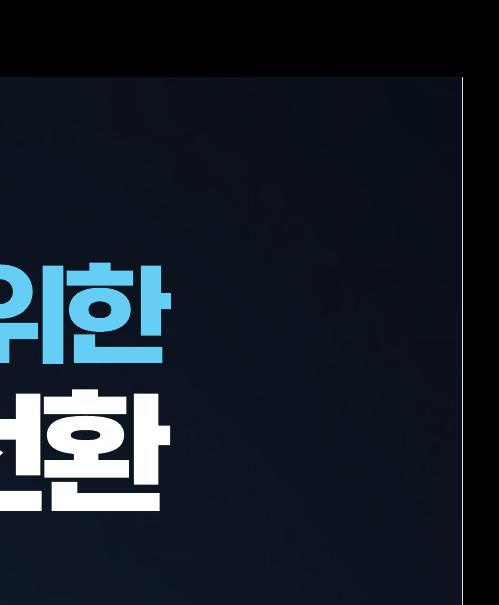

In [57]:
# img_base64_list 리스트의 20번 index 이미지를 base64 형식으로 표시합니다.
plt_img_base64(img_base64_list[20])

여기 해당 요약이 있으며, 우리는 이를 유사성 검색에 사용하기 위해 내장했습니다.

이 이미지가 우리의 `query`를 기반으로 그 요약과의 유사성 때문에 검색된 것은 상당히 합리적입니다.


In [68]:
image_summaries[20]  # image_summaries 리스트의 네 번째 요소에 접근합니다.

'검은 배경에 파란색과 흰색으로 쓰여진 한국어 텍스트.'

### RAG

이제 RAG를 실행하고 우리의 질문에 대한 답변을 종합하는 능력을 테스트해 보겠습니다.


In [67]:
# RAG 체인 실행
print(chain_multimodal_rag.invoke("테슬라 사이버트럭 내부 사진"))

테슬라 사이버트럭의 내부 사진을 보면, 이 차량이 매우 미래지향적이고 혁신적인 디자인을 가지고 있음을 알 수 있습니다. 이는 테슬라가 전기차 시장에서의 리더십을 유지하고자 하는 강한 의지를 반영합니다. 

테슬라는 전기차 시장에서의 선도적인 위치를 차지하고 있으며, 사이버트럭은 그들의 제품 라인업을 더욱 다양화하고 강화하는 중요한 모델입니다. 사이버트럭의 독특한 디자인과 기능은 많은 소비자들의 관심을 끌고 있으며, 이는 테슬라의 매출 증가와 주가 상승에 긍정적인 영향을 미칠 수 있습니다.

투자 관점에서 볼 때, 테슬라의 사이버트럭은 다음과 같은 이유로 긍정적인 신호로 해석될 수 있습니다:

1. **혁신적인 디자인과 기술**: 사이버트럭의 독특한 디자인과 첨단 기술은 시장에서의 경쟁력을 높여줄 것입니다.
2. **강력한 브랜드 인지도**: 테슬라는 이미 전 세계적으로 강력한 브랜드 인지도를 가지고 있으며, 사이버트럭은 이를 더욱 강화할 것입니다.
3. **전기차 시장의 성장**: 전기차 시장은 지속적으로 성장하고 있으며, 테슬라는 이 시장에서의 리더로서 큰 혜택을 볼 것입니다.
4. **다양화된 제품 라인업**: 사이버트럭은 테슬라의 제품 라인업을 다양화하여 더 많은 소비자층을 타겟으로 할 수 있게 합니다.

따라서, 테슬라의 주식은 장기적인 투자 관점에서 긍정적인 선택이 될 수 있습니다. 다만, 전기차 시장의 경쟁이 치열해지고 있는 만큼, 투자 시에는 시장 동향과 테슬라의 재무 상태를 지속적으로 모니터링하는 것이 중요합니다.


### 고려사항

**검색**

- 검색은 이미지 요약과 텍스트 Chunk 와의 유사성을 기반으로 수행됩니다.
- 이는 이미지 요약 검색 결과보다 다른 Text Chunk 가 경쟁 우위에 있을 경우 실패할 수 있기 때문에 신중한 고려가 필요합니다.

**이미지 크기**

- 답변 합성의 품질은 이미지 크기에 민감한 것으로 보입니다. [가이드에 명시 된 것 처럼..](https://platform.openai.com/docs/guides/vision).
